In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Libraries**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


**File Paths**

In [ ]:
BASE_DIR = '/content/drive/MyDrive/MLL/Brain Tumor data'
TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DIR  = os.path.join(BASE_DIR, 'Testing')

if not os.path.exists(BASE_DIR):
    raise FileNotFoundError("Base directory not found!")

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test  classes:", os.listdir(TEST_DIR))


Train classes: ['meningioma', 'glioma', 'notumor', 'pituitary']
Test  classes: ['glioma', 'pituitary', 'meningioma', 'notumor']


**No. of Images Per Class**

*Training data distribution*

Number of images per category in Training directory:
meningioma: 1339
glioma: 1321
notumor: 1595
pituitary: 1457


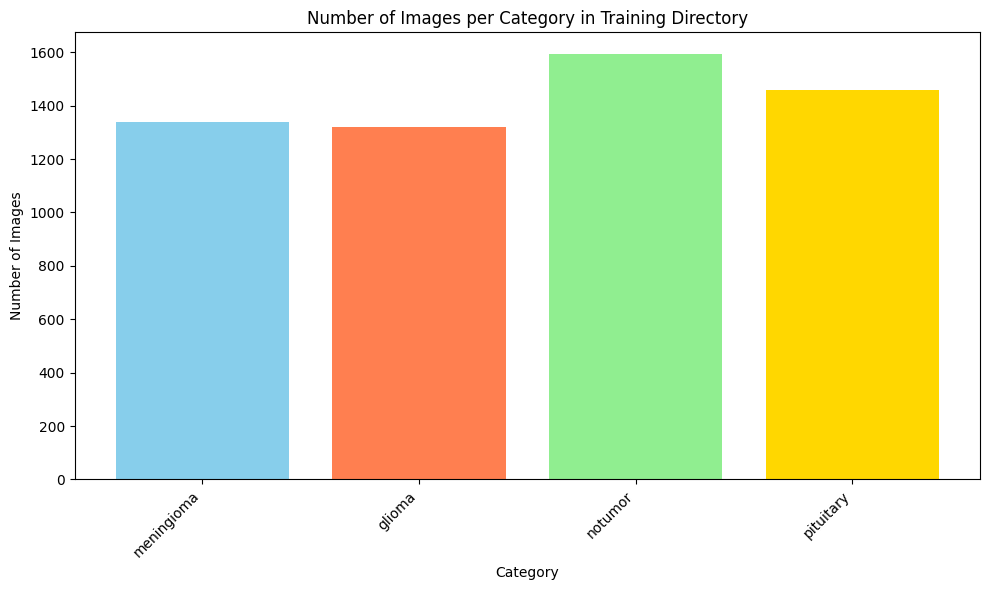

In [ ]:
categories = os.listdir(TRAIN_DIR)
image_counts = {}

for category in categories:
    category_path = os.path.join(TRAIN_DIR, category)
    count = 0
    if os.path.isdir(category_path):
        for item in os.listdir(category_path):
            item_path = os.path.join(category_path, item)
            if os.path.isfile(item_path):
                ext = os.path.splitext(item_path)[1].lower()
                if ext in ('.jpg', '.jpeg', '.png', '.gif'):
                    count += 1
    image_counts[category] = count

print("Number of images per category in Training directory:")
for category, count in image_counts.items():
    print(f"{category}: {count}")

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'coral', 'lightgreen', 'gold'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Training Directory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Testing data distribution*

Number of images per category in Testing directory:
glioma: 300
pituitary: 300
meningioma: 306
notumor: 405


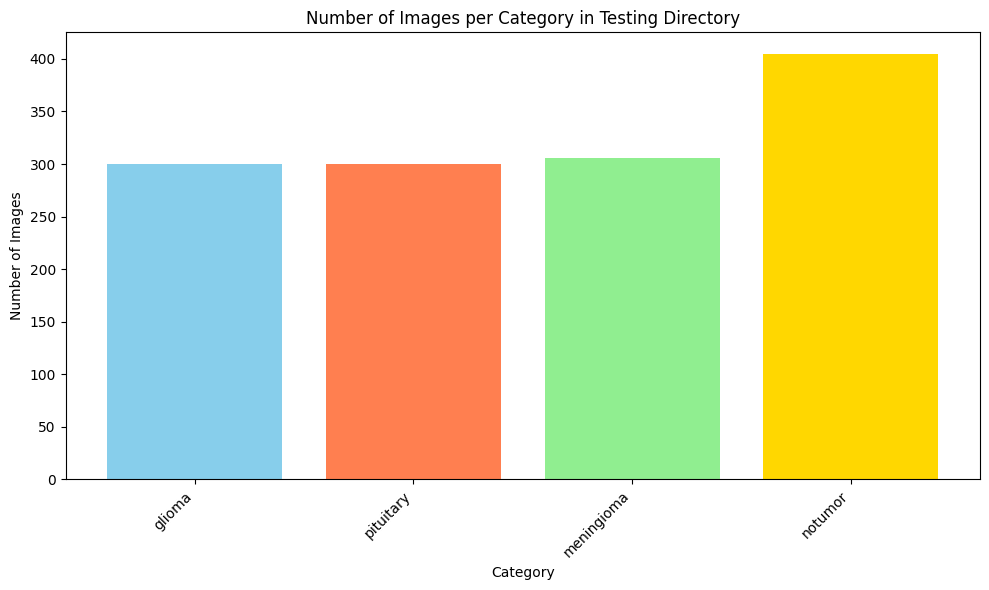

In [ ]:
categories = os.listdir(TEST_DIR)
image_counts = {}

for category in categories:
    category_path = os.path.join(TEST_DIR, category)
    count = 0
    if os.path.isdir(category_path):
        for item in os.listdir(category_path):
            item_path = os.path.join(category_path, item)
            if os.path.isfile(item_path):
                ext = os.path.splitext(item_path)[1].lower()
                if ext in ('.jpg', '.jpeg', '.png', '.gif'):
                    count += 1
    image_counts[category] = count

print("Number of images per category in Testing directory:")
for category, count in image_counts.items():
    print(f"{category}: {count}")

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color=['skyblue', 'coral', 'lightgreen', 'gold'])
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images per Category in Testing Directory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Global Parameters

In [ ]:
preprocess_func = resnet_preprocess
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [ ]:
print("Class Indices (Label Encoding):")
for class_name, label in train_generator.class_indices.items():
    print(f"  '{class_name}': {label}")

class_names_encoded = list(train_generator.class_indices.keys())
print(f"\nOrdered Class Names: {class_names_encoded}")

Class Indices (Label Encoding):
  'glioma': 0
  'meningioma': 1
  'notumor': 2
  'pituitary': 3

Ordered Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:

print("DATA GENERATORS SUMMARY")
print(f"Training samples:   {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples:       {test_generator.samples}")
print(f"Number of classes:  {train_generator.num_classes}")
print(f"Class indices:      {train_generator.class_indices}")

class_names = list(train_generator.class_indices.keys())
print(f"Class Names: {class_names}")
NUM_CLASSES = len(class_names)

DATA GENERATORS SUMMARY
Training samples:   4571
Validation samples: 1141
Test samples:       1311
Number of classes:  4
Class indices:      {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


EfficientNetB0

In [ ]:
preprocess_func = efficientnet_preprocess
train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_func,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.20,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

val_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_func,
    validation_split=0.2
)
test_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_func
)

train_generator_eff = train_datagen_eff.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator_eff = val_datagen_eff.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator_eff = test_datagen_eff.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3062 - loss: 1.4451
Epoch 1: val_accuracy improved from -inf to 0.47415, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 1350s 9s/step - accuracy: 0.3068 - loss: 1.4442 - val_accuracy: 0.4741 - val_loss: 1.2157
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.5756 - loss: 1.0476
Epoch 2: val_accuracy improved from 0.47415 to 0.50307, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.5757 - loss: 1.0473 - val_accuracy: 0.5031 - val_loss: 1.1018
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.6761 - loss: 0.8810
Epoch 3: val_accuracy improved from 0.50307 to 0.53199, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 603ms/step - accuracy: 0.6762 - loss: 0.8807 - val_accuracy: 0.5320 - val_loss: 1.0467
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.7275 - loss: 0.7507
Epoch 4: val_accuracy improved from 0.53199 to 0.55916, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 610ms/step - accuracy: 0.7275 - loss: 0.7506 - val_accuracy: 0.5592 - val_loss: 1.0129
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.7410 - loss: 0.7169
Epoch 5: val_accuracy improved from 0.55916 to 0.57318, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 604ms/step - accuracy: 0.7412 - loss: 0.7167 - val_accuracy: 0.5732 - val_loss: 0.9865
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7718 - loss: 0.6532
Epoch 6: val_accuracy improved from 0.57318 to 0.59597, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 610ms/step - accuracy: 0.7718 - loss: 0.6531 - val_accuracy: 0.5960 - val_loss: 0.9618
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7783 - loss: 0.6060
Epoch 7: val_accuracy improved from 0.59597 to 0.59772, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 594ms/step - accuracy: 0.7784 - loss: 0.6059 - val_accuracy: 0.5977 - val_loss: 0.9525
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.7942 - loss: 0.5670
Epoch 8: val_accuracy improved from 0.59772 to 0.62489, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 596ms/step - accuracy: 0.7942 - loss: 0.5671 - val_accuracy: 0.6249 - val_loss: 0.9315
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8085 - loss: 0.5423
Epoch 9: val_accuracy did not improve from 0.62489
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 603ms/step - accuracy: 0.8085 - loss: 0.5423 - val_accuracy: 0.6249 - val_loss: 0.9219
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8168 - loss: 0.5120
Epoch 10: val_accuracy improved from 0.62489 to 0.64680, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 600ms/step - accuracy: 0.8168 - loss: 0.5120 - val_accuracy: 0.6468 - val_loss: 0.8957
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8174 - loss: 0.5195
Epoch 11: val_accuracy improved from 0.64680 to 0.65381, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 602ms/step - accuracy: 0.8173 - loss: 0.5195 - val_accuracy: 0.6538 - val_loss: 0.8842
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8130 - loss: 0.5010
Epoch 12: val_accuracy improved from 0.65381 to 0.66521, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 599ms/step - accuracy: 0.8130 - loss: 0.5011 - val_accuracy: 0.6652 - val_loss: 0.8612
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.8180 - loss: 0.4961
Epoch 13: val_accuracy did not improve from 0.66521
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 597ms/step - accuracy: 0.8180 - loss: 0.4961 - val_accuracy: 0.6643 - val_loss: 0.8605
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8343 - loss: 0.4772
Epoch 14: val_accuracy improved from 0.66521 to 0.66784, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 595ms/step - accuracy: 0.8343 - loss: 0.4772 - val_accuracy: 0.6678 - val_loss: 0.8480
Epoch 15/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8298 - loss: 0.4715
Epoch 15: val_accuracy improved from 0.66784 to 0.67660, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 599ms/step - accuracy: 0.8298 - loss: 0.4715 - val_accuracy: 0.6766 - val_loss: 0.8316
Epoch 16/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8482 - loss: 0.4516
Epoch 16: val_accuracy improved from 0.67660 to 0.68098, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 594ms/step - accuracy: 0.8481 - loss: 0.4517 - val_accuracy: 0.6810 - val_loss: 0.8263
Epoch 17/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8406 - loss: 0.4483
Epoch 17: val_accuracy improved from 0.68098 to 0.68361, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 601ms/step - accuracy: 0.8406 - loss: 0.4484 - val_accuracy: 0.6836 - val_loss: 0.8203
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8331 - loss: 0.4580
Epoch 18: val_accuracy improved from 0.68361 to 0.68975, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 598ms/step - accuracy: 0.8332 - loss: 0.4579 - val_accuracy: 0.6897 - val_loss: 0.8090
Epoch 19/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8420 - loss: 0.4376
Epoch 19: val_accuracy improved from 0.68975 to 0.69062, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 627ms/step - accuracy: 0.8420 - loss: 0.4376 - val_accuracy: 0.6906 - val_loss: 0.8093
Epoch 20/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.8342 - loss: 0.4342
Epoch 20: val_accuracy did not improve from 0.69062
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 614ms/step - accuracy: 0.8342 - loss: 0.4342 - val_accuracy: 0.6906 - val_loss: 0.7982
Restoring model weights from the end of the best epoch: 19.


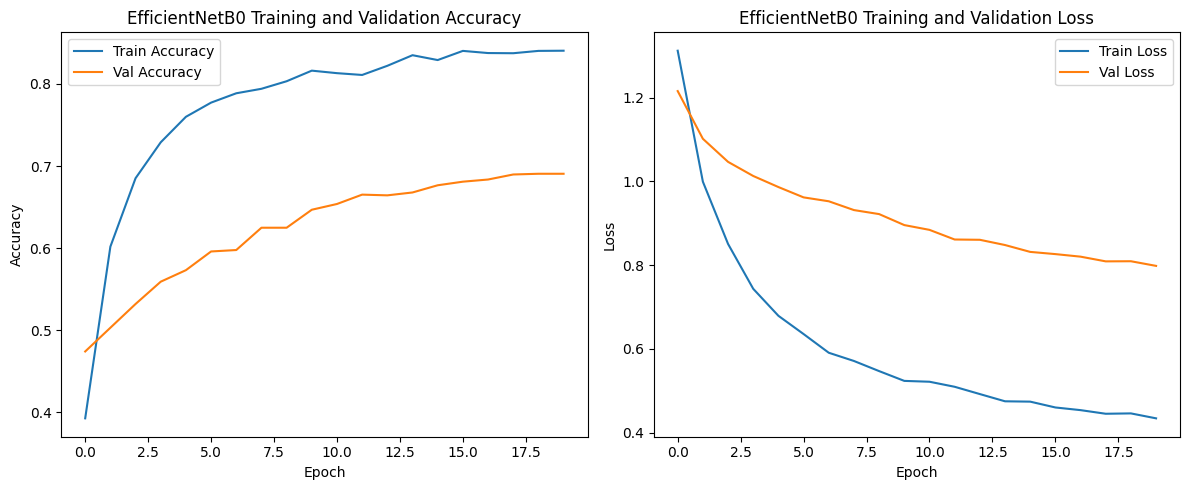

EfficientNetB0 Final Training Accuracy:   0.8405
EfficientNetB0 Final Validation Accuracy: 0.6906
EfficientNetB0 Final Training Loss:       0.4341
EfficientNetB0 Final Validation Loss:     0.7982


In [ ]:
NUM_CLASSES = train_generator_eff.num_classes

base_model_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

base_model_efficientnet.trainable = False

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=outputs)

model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_efficientnet.summary()

monitor_metric_eff = 'val_accuracy'

checkpoint_eff = ModelCheckpoint(
    '/content/best_efficientnetb0_brain_tumor.h5',
    monitor=monitor_metric_eff,
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_eff = EarlyStopping(
    monitor=monitor_metric_eff,
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
history_efficientnet = model_efficientnet.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=20,
    callbacks=[checkpoint_eff, early_stop_eff]
)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


final_train_acc_eff = history_efficientnet.history['accuracy'][-1]
final_val_acc_eff = history_efficientnet.history['val_accuracy'][-1]
final_train_loss_eff = history_efficientnet.history['loss'][-1]
final_val_loss_eff = history_efficientnet.history['val_loss'][-1]

print(f"EfficientNetB0 Final Training Accuracy:   {final_train_acc_eff:.4f}")
print(f"EfficientNetB0 Final Validation Accuracy: {final_val_acc_eff:.4f}")
print(f"EfficientNetB0 Final Training Loss:       {final_train_loss_eff:.4f}")
print(f"EfficientNetB0 Final Validation Loss:     {final_val_loss_eff:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7274 - loss: 0.7380
Epoch 1: val_accuracy improved from -inf to 0.68098, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 133s 779ms/step - accuracy: 0.7277 - loss: 0.7371 - val_accuracy: 0.6810 - val_loss: 1.0876
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8114 - loss: 0.5477
Epoch 2: val_accuracy improved from 0.68098 to 0.75285, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 632ms/step - accuracy: 0.8115 - loss: 0.5476 - val_accuracy: 0.7528 - val_loss: 0.7933
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.8166 - loss: 0.5487
Epoch 3: val_accuracy did not improve from 0.75285
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 611ms/step - accuracy: 0.8167 - loss: 0.5486 - val_accuracy: 0.7520 - val_loss: 0.8047
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8321 - loss: 0.5326
Epoch 4: val_accuracy did not improve from 0.75285
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 604ms/step - accuracy: 0.8321 - loss: 0.5328 - val_accuracy: 0.7204 - val_loss: 1.0938
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.8292 - loss: 0.5384
Epoch 5: val_accuracy did not improve from 0.75285
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 611ms/step - accuracy: 0.8292 - loss: 0.5384 - val_accuracy: 0.7432 - val_loss: 1.0937
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8264 - loss: 0.5686
Epoch 6: val_ac

143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 611ms/step - accuracy: 0.8390 - loss: 0.5239 - val_accuracy: 0.7625 - val_loss: 0.8245
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8252 - loss: 0.5675
Epoch 8: val_accuracy improved from 0.76249 to 0.79842, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 609ms/step - accuracy: 0.8252 - loss: 0.5674 - val_accuracy: 0.7984 - val_loss: 0.6923
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8173 - loss: 0.6167
Epoch 9: val_accuracy did not improve from 0.79842
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 601ms/step - accuracy: 0.8175 - loss: 0.6163 - val_accuracy: 0.7940 - val_loss: 0.7095
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8522 - loss: 0.4916
Epoch 10: val_accuracy did not improve from 0.79842
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 599ms/step - accuracy: 0.8521 - loss: 0.4918 - val_accuracy: 0.7204 - val_loss: 1.0868
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8430 - loss: 0.5719
Epoch 11: val_accuracy did not improve from 0.79842
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 600ms/step - accuracy: 0.8430 - loss: 0.5719 - val_accuracy: 0.7721 - val_loss: 0.9003
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.8480 - loss: 0.4835
Epoch 12: 

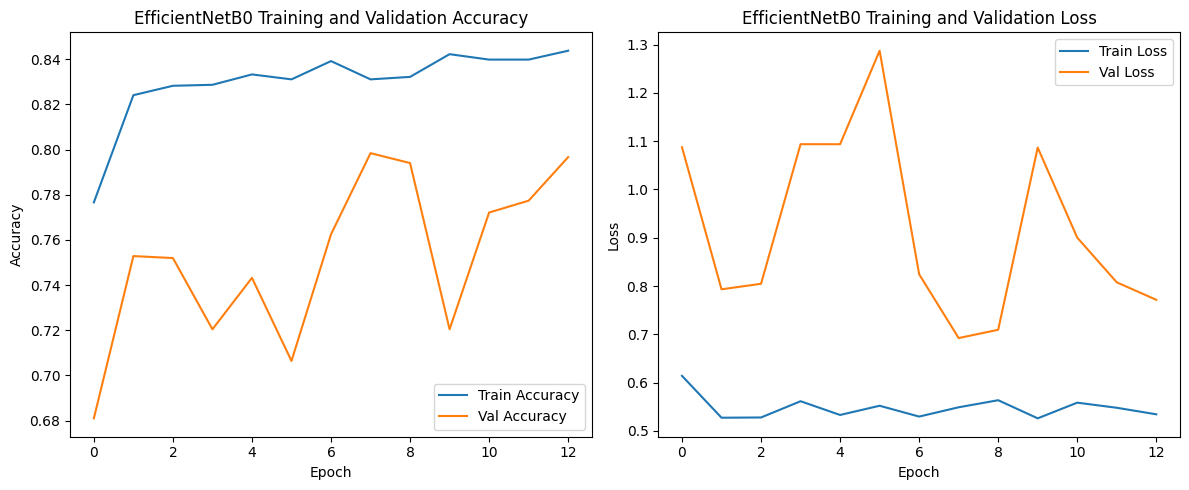

EfficientNetB0 Final Training Accuracy:   0.8438
EfficientNetB0 Final Validation Accuracy: 0.7967
EfficientNetB0 Final Training Loss:       0.5344
EfficientNetB0 Final Validation Loss:     0.7715


In [ ]:
NUM_CLASSES = train_generator_eff.num_classes

base_model_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

base_model_efficientnet.trainable = False

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=outputs)

model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-2),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_efficientnet.summary()

monitor_metric_eff = 'val_accuracy'

checkpoint_eff = ModelCheckpoint(
    '/content/best_efficientnetb0_brain_tumor.h5',
    monitor=monitor_metric_eff,
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_eff = EarlyStopping(
    monitor=monitor_metric_eff,
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
history_efficientnet = model_efficientnet.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=20,
    callbacks=[checkpoint_eff, early_stop_eff]
)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


final_train_acc_eff = history_efficientnet.history['accuracy'][-1]
final_val_acc_eff = history_efficientnet.history['val_accuracy'][-1]
final_train_loss_eff = history_efficientnet.history['loss'][-1]
final_val_loss_eff = history_efficientnet.history['val_loss'][-1]

print(f"EfficientNetB0 Final Training Accuracy:   {final_train_acc_eff:.4f}")
print(f"EfficientNetB0 Final Validation Accuracy: {final_val_acc_eff:.4f}")
print(f"EfficientNetB0 Final Training Loss:       {final_train_loss_eff:.4f}")
print(f"EfficientNetB0 Final Validation Loss:     {final_val_loss_eff:.4f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.3158 - loss: 1.4423
Epoch 1: val_accuracy improved from -inf to 0.48116, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 129s 757ms/step - accuracy: 0.3163 - loss: 1.4414 - val_accuracy: 0.4812 - val_loss: 1.1731
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.5179 - loss: 1.0954
Epoch 2: val_accuracy improved from 0.48116 to 0.52848, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 597ms/step - accuracy: 0.5182 - loss: 1.0950 - val_accuracy: 0.5285 - val_loss: 1.0780
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.6372 - loss: 0.9187
Epoch 3: val_accuracy improved from 0.52848 to 0.53812, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 598ms/step - accuracy: 0.6373 - loss: 0.9184 - val_accuracy: 0.5381 - val_loss: 1.0279
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.6996 - loss: 0.7962
Epoch 4: val_accuracy improved from 0.53812 to 0.56179, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 598ms/step - accuracy: 0.6997 - loss: 0.7961 - val_accuracy: 0.5618 - val_loss: 0.9927
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7274 - loss: 0.7323
Epoch 5: val_accuracy improved from 0.56179 to 0.59071, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 585ms/step - accuracy: 0.7275 - loss: 0.7321 - val_accuracy: 0.5907 - val_loss: 0.9550
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.7449 - loss: 0.6806
Epoch 6: val_accuracy improved from 0.59071 to 0.60911, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 591ms/step - accuracy: 0.7449 - loss: 0.6805 - val_accuracy: 0.6091 - val_loss: 0.9424
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7779 - loss: 0.6287
Epoch 7: val_accuracy improved from 0.60911 to 0.62927, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 599ms/step - accuracy: 0.7779 - loss: 0.6286 - val_accuracy: 0.6293 - val_loss: 0.9250
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7739 - loss: 0.6041
Epoch 8: val_accuracy improved from 0.62927 to 0.63628, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 595ms/step - accuracy: 0.7739 - loss: 0.6041 - val_accuracy: 0.6363 - val_loss: 0.9276
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7862 - loss: 0.5815
Epoch 9: val_accuracy improved from 0.63628 to 0.64855, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 632ms/step - accuracy: 0.7862 - loss: 0.5815 - val_accuracy: 0.6486 - val_loss: 0.9094
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7911 - loss: 0.5548
Epoch 10: val_accuracy improved from 0.64855 to 0.65469, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 607ms/step - accuracy: 0.7911 - loss: 0.5548 - val_accuracy: 0.6547 - val_loss: 0.8936
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.8021 - loss: 0.5383
Epoch 11: val_accuracy did not improve from 0.65469
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 592ms/step - accuracy: 0.8021 - loss: 0.5383 - val_accuracy: 0.6529 - val_loss: 0.8909
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8024 - loss: 0.5240
Epoch 12: val_accuracy improved from 0.65469 to 0.66608, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 594ms/step - accuracy: 0.8024 - loss: 0.5241 - val_accuracy: 0.6661 - val_loss: 0.8697
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8074 - loss: 0.5350
Epoch 13: val_accuracy improved from 0.66608 to 0.66871, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 596ms/step - accuracy: 0.8075 - loss: 0.5348 - val_accuracy: 0.6687 - val_loss: 0.8571
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8184 - loss: 0.5089
Epoch 14: val_accuracy improved from 0.66871 to 0.67835, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 603ms/step - accuracy: 0.8184 - loss: 0.5089 - val_accuracy: 0.6784 - val_loss: 0.8450
Epoch 15/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.8176 - loss: 0.5057
Epoch 15: val_accuracy did not improve from 0.67835
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 591ms/step - accuracy: 0.8177 - loss: 0.5056 - val_accuracy: 0.6722 - val_loss: 0.8416
Epoch 16/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.8207 - loss: 0.4850
Epoch 16: val_accuracy improved from 0.67835 to 0.68273, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 592ms/step - accuracy: 0.8207 - loss: 0.4850 - val_accuracy: 0.6827 - val_loss: 0.8242
Epoch 17/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.8227 - loss: 0.4689
Epoch 17: val_accuracy improved from 0.68273 to 0.69062, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 598ms/step - accuracy: 0.8227 - loss: 0.4689 - val_accuracy: 0.6906 - val_loss: 0.8179
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.8344 - loss: 0.4535
Epoch 18: val_accuracy improved from 0.69062 to 0.69413, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 606ms/step - accuracy: 0.8344 - loss: 0.4535 - val_accuracy: 0.6941 - val_loss: 0.8144
Epoch 19/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8352 - loss: 0.4496
Epoch 19: val_accuracy improved from 0.69413 to 0.69763, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 595ms/step - accuracy: 0.8352 - loss: 0.4497 - val_accuracy: 0.6976 - val_loss: 0.8047
Epoch 20/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.8433 - loss: 0.4435
Epoch 20: val_accuracy improved from 0.69763 to 0.69939, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 596ms/step - accuracy: 0.8433 - loss: 0.4435 - val_accuracy: 0.6994 - val_loss: 0.8006
Restoring model weights from the end of the best epoch: 20.


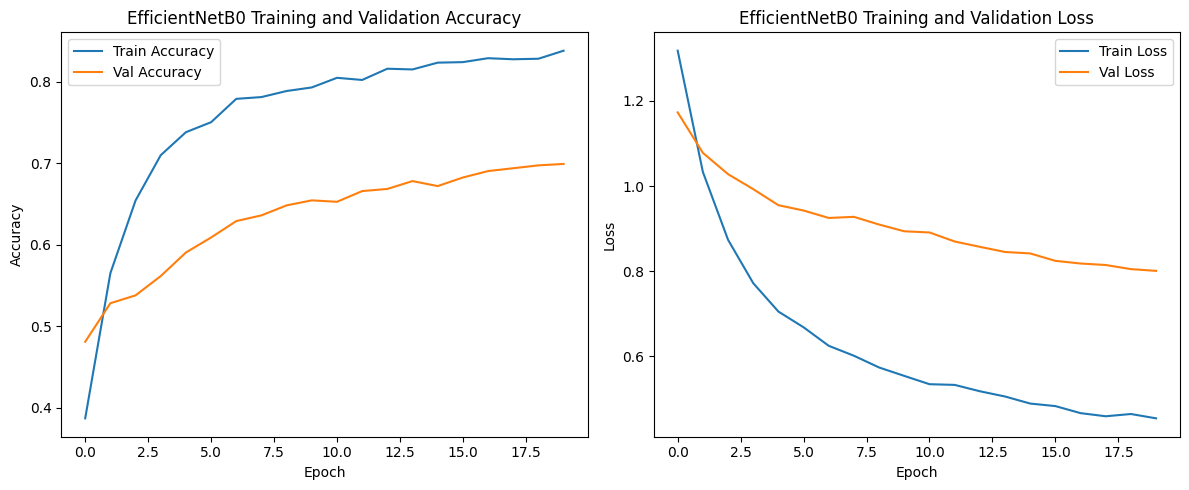

EfficientNetB0 Final Training Accuracy:   0.8383
EfficientNetB0 Final Validation Accuracy: 0.6994
EfficientNetB0 Final Training Loss:       0.4540
EfficientNetB0 Final Validation Loss:     0.8006


In [ ]:
NUM_CLASSES = train_generator_eff.num_classes

base_model_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

base_model_efficientnet.trainable = False

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=outputs)

model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

monitor_metric_eff = 'val_accuracy'

checkpoint_eff = ModelCheckpoint(
    '/content/best_efficientnetb0_brain_tumor.h5',
    monitor=monitor_metric_eff,
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_eff = EarlyStopping(
    monitor=monitor_metric_eff,
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
history_efficientnet = model_efficientnet.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=20,
    callbacks=[checkpoint_eff, early_stop_eff]
)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


final_train_acc_eff = history_efficientnet.history['accuracy'][-1]
final_val_acc_eff = history_efficientnet.history['val_accuracy'][-1]
final_train_loss_eff = history_efficientnet.history['loss'][-1]
final_val_loss_eff = history_efficientnet.history['val_loss'][-1]

print(f"EfficientNetB0 Final Training Accuracy:   {final_train_acc_eff:.4f}")
print(f"EfficientNetB0 Final Validation Accuracy: {final_val_acc_eff:.4f}")
print(f"EfficientNetB0 Final Training Loss:       {final_train_loss_eff:.4f}")
print(f"EfficientNetB0 Final Validation Loss:     {final_val_loss_eff:.4f}")

In [ ]:
NUM_CLASSES = train_generator_eff.num_classes

base_model_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

for layer in base_model_efficientnet.layers[-30:]:
    layer.trainable = True

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=outputs)

model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

monitor_metric_eff = 'val_accuracy'

checkpoint_eff = ModelCheckpoint(
    '/content/best_efficientnetb0_brain_tumor.h5',
    monitor=monitor_metric_eff,
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_eff = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history_finetune = model_efficientnet.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=25,
    callbacks=[checkpoint_eff, early_stop_eff]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.6641 - loss: 0.8317
Epoch 1: val_accuracy improved from -inf to 0.82384, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.6651 - loss: 0.8297 - val_accuracy: 0.8238 - val_loss: 0.4193
Epoch 2/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9226 - loss: 0.2254
Epoch 2: val_accuracy improved from 0.82384 to 0.89833, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 628ms/step - accuracy: 0.9227 - loss: 0.2253 - val_accuracy: 0.8983 - val_loss: 0.2805
Epoch 3/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9518 - loss: 0.1443
Epoch 3: val_accuracy improved from 0.89833 to 0.93076, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 632ms/step - accuracy: 0.9518 - loss: 0.1442 - val_accuracy: 0.9308 - val_loss: 0.1943
Epoch 4/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9633 - loss: 0.1129
Epoch 4: val_accuracy did not improve from 0.93076
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 626ms/step - accuracy: 0.9633 - loss: 0.1128 - val_accuracy: 0.9071 - val_loss: 0.2224
Epoch 5/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9679 - loss: 0.0880
Epoch 5: val_accuracy did not improve from 0.93076
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 621ms/step - accuracy: 0.9680 - loss: 0.0879 - val_accuracy: 0.9264 - val_loss: 0.2061
Epoch 6/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9873 - loss: 0.0450
Epoch 6: val_accuracy improved from 0.93076 to 0.93953, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 635ms/step - accuracy: 0.9873 - loss: 0.0451 - val_accuracy: 0.9395 - val_loss: 0.1698
Epoch 7/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9851 - loss: 0.0451
Epoch 7: val_accuracy improved from 0.93953 to 0.94040, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 643ms/step - accuracy: 0.9851 - loss: 0.0451 - val_accuracy: 0.9404 - val_loss: 0.1471
Epoch 8/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9812 - loss: 0.0542
Epoch 8: val_accuracy did not improve from 0.94040
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 661ms/step - accuracy: 0.9812 - loss: 0.0541 - val_accuracy: 0.9343 - val_loss: 0.2150
Epoch 9/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9863 - loss: 0.0422
Epoch 9: val_accuracy improved from 0.94040 to 0.96056, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 633ms/step - accuracy: 0.9863 - loss: 0.0422 - val_accuracy: 0.9606 - val_loss: 0.1289
Epoch 10/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9872 - loss: 0.0437
Epoch 10: val_accuracy did not improve from 0.96056
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 622ms/step - accuracy: 0.9872 - loss: 0.0437 - val_accuracy: 0.9430 - val_loss: 0.1752
Epoch 11/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9892 - loss: 0.0283
Epoch 11: val_accuracy did not improve from 0.96056
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 625ms/step - accuracy: 0.9892 - loss: 0.0282 - val_accuracy: 0.9369 - val_loss: 0.1840
Epoch 12/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.9951 - loss: 0.0222
Epoch 12: val_accuracy did not improve from 0.96056
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 615ms/step - accuracy: 0.9951 - loss: 0.0222 - val_accuracy: 0.9527 - val_loss: 0.1483
Epoch 13/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.9959 - loss: 0.0180
Epoch 13

143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 628ms/step - accuracy: 0.9934 - loss: 0.0215 - val_accuracy: 0.9614 - val_loss: 0.1199
Epoch 15/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9942 - loss: 0.0209
Epoch 15: val_accuracy did not improve from 0.96144
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 625ms/step - accuracy: 0.9941 - loss: 0.0209 - val_accuracy: 0.9500 - val_loss: 0.2005
Epoch 16/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9931 - loss: 0.0204
Epoch 16: val_accuracy did not improve from 0.96144
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 628ms/step - accuracy: 0.9931 - loss: 0.0204 - val_accuracy: 0.9500 - val_loss: 0.1815
Epoch 17/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9949 - loss: 0.0150
Epoch 17: val_accuracy did not improve from 0.96144
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 627ms/step - accuracy: 0.9949 - loss: 0.0150 - val_accuracy: 0.9089 - val_loss: 0.3335
Epoch 18/25
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9944 - loss: 0.0190
Epoch 18

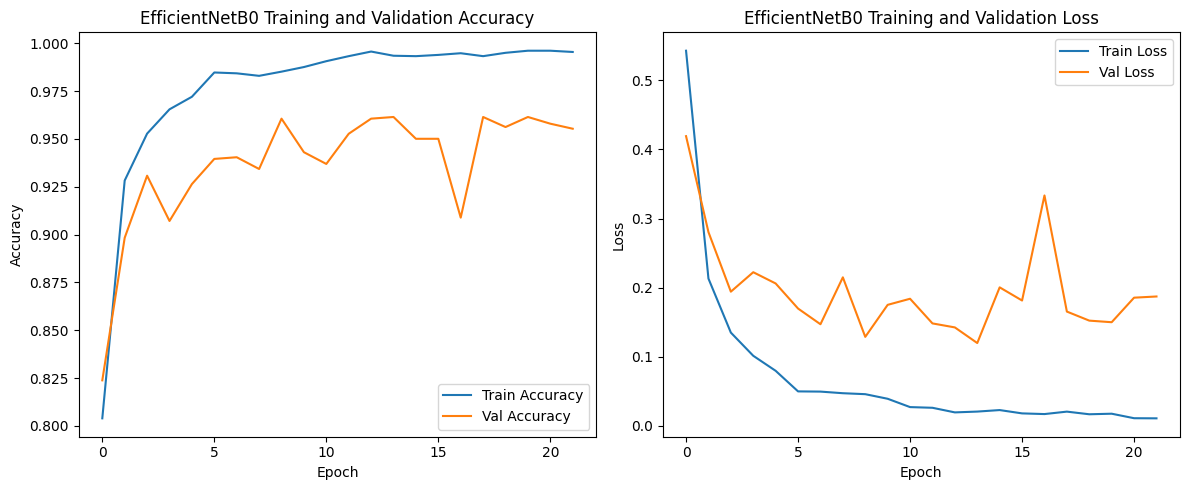

In [ ]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


final_train_acc_eff = history_finetune.history['accuracy'][-1]
final_val_acc_eff = history_finetune.history['val_accuracy'][-1]
final_train_loss_eff = history_finetune.history['loss'][-1]
final_val_loss_eff = history_finetune.history['val_loss'][-1]

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.7003 - loss: 0.7646
Epoch 1: val_accuracy improved from -inf to 0.82296, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 207s 962ms/step - accuracy: 0.7011 - loss: 0.7627 - val_accuracy: 0.8230 - val_loss: 0.4787
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9117 - loss: 0.2433
Epoch 2: val_accuracy improved from 0.82296 to 0.88344, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 629ms/step - accuracy: 0.9118 - loss: 0.2431 - val_accuracy: 0.8834 - val_loss: 0.2776
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9511 - loss: 0.1440
Epoch 3: val_accuracy improved from 0.88344 to 0.89746, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 631ms/step - accuracy: 0.9511 - loss: 0.1439 - val_accuracy: 0.8975 - val_loss: 0.2492
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9633 - loss: 0.1064
Epoch 4: val_accuracy did not improve from 0.89746
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 619ms/step - accuracy: 0.9633 - loss: 0.1064 - val_accuracy: 0.8861 - val_loss: 0.3174
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9678 - loss: 0.0856
Epoch 5: val_accuracy improved from 0.89746 to 0.91762, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 636ms/step - accuracy: 0.9678 - loss: 0.0855 - val_accuracy: 0.9176 - val_loss: 0.2178
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.9794 - loss: 0.0593
Epoch 6: val_accuracy improved from 0.91762 to 0.92550, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 644ms/step - accuracy: 0.9794 - loss: 0.0593 - val_accuracy: 0.9255 - val_loss: 0.2231
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9782 - loss: 0.0594
Epoch 7: val_accuracy improved from 0.92550 to 0.93514, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 92s 642ms/step - accuracy: 0.9782 - loss: 0.0594 - val_accuracy: 0.9351 - val_loss: 0.1874
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9785 - loss: 0.0622
Epoch 8: val_accuracy improved from 0.93514 to 0.94303, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 631ms/step - accuracy: 0.9785 - loss: 0.0621 - val_accuracy: 0.9430 - val_loss: 0.1718
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9833 - loss: 0.0532
Epoch 9: val_accuracy did not improve from 0.94303
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 624ms/step - accuracy: 0.9833 - loss: 0.0531 - val_accuracy: 0.9369 - val_loss: 0.1767
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.9924 - loss: 0.0293
Epoch 10: val_accuracy did not improve from 0.94303
143/143 ━━━━━━━━━━━━━━━━━━━━ 93s 650ms/step - accuracy: 0.9924 - loss: 0.0293 - val_accuracy: 0.9325 - val_loss: 0.2188
Restoring model weights from the end of the best epoch: 8.


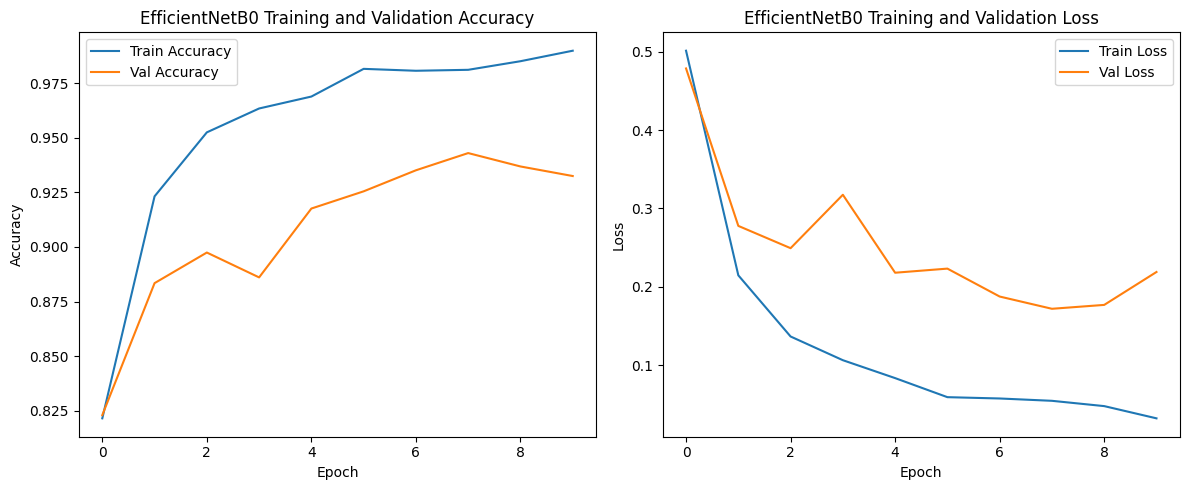

In [ ]:
NUM_CLASSES = train_generator_eff.num_classes

base_model_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)
# Unfreeze last 30 layers of EfficientNetB0
for layer in base_model_efficientnet.layers[-30:]:
    layer.trainable = True

# Add custom classification head
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=outputs)


model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


monitor_metric_eff = 'val_accuracy'

checkpoint_eff = ModelCheckpoint(
    '/content/best_efficientnetb0_brain_tumor.h5',
    monitor=monitor_metric_eff,
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_eff = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history_finetune = model_efficientnet.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=10,
    callbacks=[checkpoint_eff, early_stop_eff]
)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


final_train_acc_eff = history_finetune.history['accuracy'][-1]
final_val_acc_eff = history_finetune.history['val_accuracy'][-1]
final_train_loss_eff = history_finetune.history['loss'][-1]
final_val_loss_eff = history_finetune.history['val_loss'][-1]


print(f"EfficientNetB0 Final Training Accuracy:   {final_train_acc_eff:.4f}")
print(f"EfficientNetB0 Final Validation Accuracy: {final_val_acc_eff:.4f}")
print(f"EfficientNetB0 Final Training Loss:       {final_train_loss_eff:.4f}")
print(f"EfficientNetB0 Final Validation Loss:     {final_val_loss_eff:.4f}")


Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.7140 - loss: 0.7613
Epoch 1: val_accuracy improved from -inf to 0.82209, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 209s 969ms/step - accuracy: 0.7148 - loss: 0.7594 - val_accuracy: 0.8221 - val_loss: 0.4574
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9191 - loss: 0.2266
Epoch 2: val_accuracy improved from 0.82209 to 0.87555, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 631ms/step - accuracy: 0.9192 - loss: 0.2264 - val_accuracy: 0.8755 - val_loss: 0.3351
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.9483 - loss: 0.1438
Epoch 3: val_accuracy improved from 0.87555 to 0.92025, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 627ms/step - accuracy: 0.9483 - loss: 0.1438 - val_accuracy: 0.9202 - val_loss: 0.2262
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.9676 - loss: 0.1080
Epoch 4: val_accuracy improved from 0.92025 to 0.92463, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 624ms/step - accuracy: 0.9676 - loss: 0.1080 - val_accuracy: 0.9246 - val_loss: 0.2174
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.9703 - loss: 0.0768
Epoch 5: val_accuracy did not improve from 0.92463
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 618ms/step - accuracy: 0.9703 - loss: 0.0768 - val_accuracy: 0.9229 - val_loss: 0.2208
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.9796 - loss: 0.0618
Epoch 6: val_accuracy improved from 0.92463 to 0.93514, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 629ms/step - accuracy: 0.9796 - loss: 0.0618 - val_accuracy: 0.9351 - val_loss: 0.1847
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9818 - loss: 0.0554
Epoch 7: val_accuracy improved from 0.93514 to 0.94391, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 634ms/step - accuracy: 0.9819 - loss: 0.0554 - val_accuracy: 0.9439 - val_loss: 0.1746
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.9864 - loss: 0.0410
Epoch 8: val_accuracy improved from 0.94391 to 0.94741, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 627ms/step - accuracy: 0.9864 - loss: 0.0409 - val_accuracy: 0.9474 - val_loss: 0.1574
Epoch 9/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9909 - loss: 0.0308
Epoch 9: val_accuracy improved from 0.94741 to 0.96144, saving model to /content/best_efficientnetb0_brain_tumor.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 91s 635ms/step - accuracy: 0.9909 - loss: 0.0308 - val_accuracy: 0.9614 - val_loss: 0.1183
Epoch 10/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.9889 - loss: 0.0350
Epoch 10: val_accuracy did not improve from 0.96144
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 624ms/step - accuracy: 0.9889 - loss: 0.0350 - val_accuracy: 0.9334 - val_loss: 0.2077
Restoring model weights from the end of the best epoch: 9.


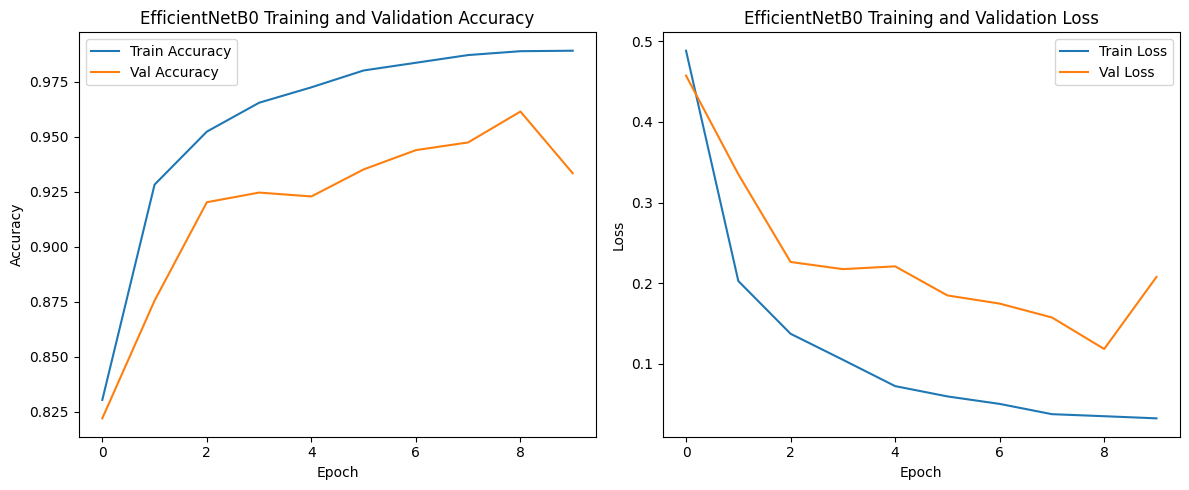

EfficientNetB0 Final Training Accuracy:   0.9891
EfficientNetB0 Final Validation Accuracy: 0.9334
EfficientNetB0 Final Training Loss:       0.0323
EfficientNetB0 Final Validation Loss:     0.2077


In [ ]:
NUM_CLASSES = train_generator_eff.num_classes

base_model_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

for layer in base_model_efficientnet.layers[-30:]:
    layer.trainable = True

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=outputs)

model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

monitor_metric_eff = 'val_accuracy'

checkpoint_eff = ModelCheckpoint(
    '/content/best_efficientnetb0_brain_tumor.h5',
    monitor=monitor_metric_eff,
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop_eff = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

history_finetune = model_efficientnet.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=10,
    callbacks=[checkpoint_eff, early_stop_eff]
)

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


final_train_acc_eff = history_finetune.history['accuracy'][-1]
final_val_acc_eff = history_finetune.history['val_accuracy'][-1]
final_train_loss_eff = history_finetune.history['loss'][-1]
final_val_loss_eff = history_finetune.history['val_loss'][-1]


print(f"EfficientNetB0 Final Training Accuracy:   {final_train_acc_eff:.4f}")
print(f"EfficientNetB0 Final Validation Accuracy: {final_val_acc_eff:.4f}")
print(f"EfficientNetB0 Final Training Loss:       {final_train_loss_eff:.4f}")
print(f"EfficientNetB0 Final Validation Loss:     {final_val_loss_eff:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 388s 10s/step - accuracy: 0.9655 - loss: 0.1087

EfficientNetB0 Test Loss: 0.0716
EfficientNetB0 Test Accuracy: 0.9802
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step

EfficientNetB0 Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       300
  meningioma       0.97      0.96      0.97       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



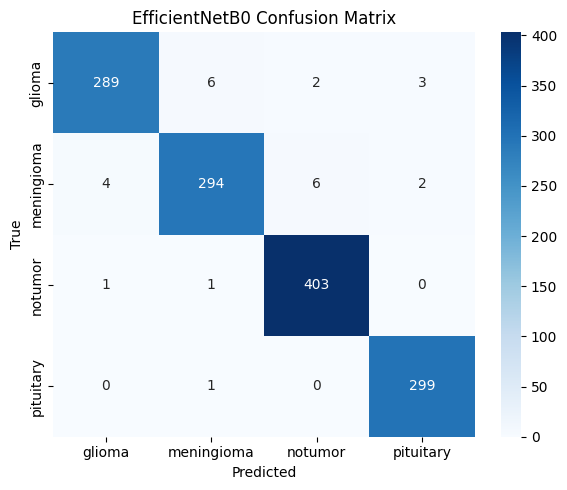

In [ ]:
test_generator_eff.reset()
test_loss_eff, test_acc_eff = model_efficientnet.evaluate(test_generator_eff, verbose=1)
print(f"\nEfficientNetB0 Test Loss: {test_loss_eff:.4f}")
print(f"EfficientNetB0 Test Accuracy: {test_acc_eff:.4f}")

test_generator_eff.reset()
y_true_eff = test_generator_eff.classes
y_pred_prob_eff = model_efficientnet.predict(test_generator_eff, verbose=1)
y_pred_eff = np.argmax(y_pred_prob_eff, axis=1)

class_indices_eff = test_generator_eff.class_indices
target_names_eff = list(class_indices_eff.keys())

print("\nEfficientNetB0 Classification Report:\n")
print(classification_report(y_true_eff, y_pred_eff, target_names=target_names_eff))

# Confusion Matrix
cm_eff = confusion_matrix(y_true_eff, y_pred_eff)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_eff,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names_eff,
    yticklabels=target_names_eff
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EfficientNetB0 Confusion Matrix')
plt.tight_layout()
plt.show()